<a href="https://colab.research.google.com/github/benwynia/CNNs/blob/main/MNIST_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Simple Generative Adversarial Network**

MNIST is a dataset of handwritten digits that is commonly used for training and testing in the field of machine learning, particularly in image recognition tasks. Here are some key details about the MNIST dataset:

**Contents:** It consists of 70,000 images of handwritten digits from '0' to '9'. Each image is a 28x28 pixel grayscale image where each pixel represents an intensity value.

**Purpose:** MNIST is widely used as a benchmark dataset for algorithms designed to recognize visual patterns. It serves as a testbed to evaluate the performance of different machine learning models, especially those in the field of computer vision.

**Usage:** The dataset is typically split into a training set of 60,000 images and a test set of 10,000 images. This allows machine learning practitioners to train models on the larger set and then test their performance on the separate set to gauge how well the model might perform on data it hasn't seen before.

**Significance:** Because of its simplicity and the extensive use in the machine learning community, MNIST is often referred to as the "Hello World" of machine learning for image recognition. It provides a straightforward dataset that can be used to illustrate the basic techniques in machine learning and computer vision.


In [5]:
#!pip install pytorch-lightning

In [6]:
# Import libraries

import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt

import pytorch_lightning as pl


random_seed = 42
torch.manual_seed(random_seed)

BATCH_SIZE=128
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS=int(os.cpu_count() / 2)

**Create a Class for managing MNIST data**

In [7]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./data", batch_size=32, num_workers=4):
        """
        Initialize the data module.

        Parameters:
        - data_dir (str): Directory to store the MNIST data.
        - batch_size (int): How many samples per batch to load.
        - num_workers (int): How many subprocesses to use for data loading.
        """
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        # Define transformations to apply to each data item
        self.transform = transforms.Compose([
            transforms.ToTensor(),  # Convert images to PyTorch tensors
            transforms.Normalize((0.1307,), (0.3081,)),  # Normalize images using mean and std dev
        ])

    def prepare_data(self):
        """
        Download the MNIST dataset if it's not already available.
        """
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        """
        Prepare datasets for training, validation, and testing phases.

        Parameters:
        - stage (str): Current stage (fit or test)
        """
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        """
        Return the DataLoader for training data.
        """
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        """
        Return the DataLoader for validation data.
        """
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        """
        Return the DataLoader for testing data.
        """
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

# Discriminator Code

The Discriminator class defined in the Python code is an integral component of a neural network, specifically designed for determining whether given input images are real or fake.

Here’s a breakdown of how this discriminator operates:

**Initialization:** The discriminator is built upon a simple Convolutional Neural Network (CNN) architecture. Initially, it sets up convolutional layers and dropout layers:

conv1 and conv2 are convolutional layers that help the model in understanding and capturing the spatial hierarchies in images by filtering the input images with learned kernels.
conv2_drop is a dropout layer applied after the second convolutional layer, which randomly zeros some of the elements of the input tensor with a certain probability during training. This prevents overfitting by ensuring that the network does not rely too much on any particular set of features.
Forward Pass: The forward method defines how the input data (x) flows through the network:

Input data is first passed through conv1, then through a ReLU activation function, and pooled using max pooling to reduce spatial dimensions.
The output then goes through the second convolutional layer (conv2), another ReLU activation, and another max pooling step. After this, it is passed through the dropout layer (conv2_drop) to randomly disable some neurons, enhancing the generalization capabilities of the model.
The data, which is still in a matrix form, needs to be flattened into a vector before it can be fed into fully connected layers. This flattening is done next.
The flattened data is processed through two fully connected layers (fc1 and fc2) with ReLU activation and a dropout applied between them to further mitigate the risk of overfitting.
The final layer outputs a single value that represents the probability of the input image being real or fake. This value is passed through a sigmoid function, which squashes the output between 0 and 1, making it easier to classify the image as real (closer to 1) or fake (closer to 0).
Overall, the Discriminator uses a combination of convolutional layers for feature extraction and fully connected layers for classification, leveraging dropout for robustness against overfitting, thus making it effective in distinguishing between authentic and counterfeit images.

In [8]:

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)

# Generator

### 1. __init__ - Initialization
This function initializes the Generator's architecture:

latent_dim: The dimensionality of the random noise vector that serves as input.
Layers:
- **lin1:** A linear layer that transforms the input noise vector into a format suitable for convolutional operations, starting the process to reshape it into a 2D image.
- **ct1 and ct2:** Convolutional transpose layers (also known as deconvolutional layers) that gradually upscale the input while adding more details, helping the network learn how to construct higher-resolution features.
- **conv:** A convolutional layer that fine-tunes the details and adjusts the dimensions to produce the final output image.

### 2. forward - Forward Pass
Defines how the input data (random noise) flows through the generator:

- **Input Transformation:** The input noise is first processed by lin1 and activated using a ReLU function to introduce non-linearity.
- **Reshaping:** After activation, the output is reshaped to match the dimensional requirements of subsequent convolutional transpose layers. It's reshaped into a batch of images with 64 feature maps of 7x7 pixels.
- **Upscaling and Feature Learning:**
**ct1: **The first upscaling step enlarges the feature maps to 16x16 pixels, doubling the size and halving the depth to 32 feature maps, adding finer details.
**ct2:** Continues to upscale to an even larger size of 34x34 pixels, further reducing the depth to 16 feature maps. Each step involves a ReLU activation to maintain non-linearity.
**Final Convolution:** The output from ct2 is then passed through a final convolutional layer that adjusts the final output size to 28x28 pixels and reduces the depth to a single feature map, representing the grayscale image.

### Summary
The Generator class acts as an "artist" learning to create realistic images from abstract input (noise). Through a series of transformations, it builds complexity from simplicity. This process involves expanding and reshaping the input, adding details through upscaling, and finalizing the image to match the expected format. Each layer and function within the generator strategically contributes to the creation of a believable image from randomized data, a core component of GAN's functionality.

In [9]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 7*7*64)  # [n, 256, 7, 7]
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2) # [n, 64, 16, 16]
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2) # [n, 16, 34, 34]
        self.conv = nn.Conv2d(16, 1, kernel_size=7)  # [n, 1, 28, 28]


    def forward(self, x):
        x = self.lin1(x)
        x = F.relu(x)
        x = x.view(-1, 64, 7, 7)  #256
        x = self.ct1(x)
        x = F.relu(x)
        x = self.ct2(x)
        x = F.relu(x)
        return self.conv(x)

# GAN

### 1. __init__ - Initialization
This function initializes the GAN model. Parameters include:

latent_dim: The dimensionality of the input noise vector fed into the generator.
lr: Learning rate for the optimizer.
b1, b2: Coefficients used for computing running averages of gradient and its square in Adam optimizer, influencing the momentum.
The function sets up:

A generator to create fake images from noise.
A discriminator to differentiate between real and fake images.
validation_z: A fixed batch of random noise for validating the generator's output.
Disables PyTorch Lightning’s automatic optimization to manually handle backpropagation.

### 2. forward - Forward Pass
Allows the model to generate an output directly from an input noise vector z, using the generator part of the GAN. This function is typically used for inference.

### 3. adversarial_loss - Loss Calculation
Computes the binary cross-entropy loss, which is used to measure how well the generator fools the discriminator and how well the discriminator distinguishes real images from fake ones. y_hat is the predicted probability by the discriminator, and y is the true label (real or fake).

### 4. training_step - Training Logic
Defines the core training logic for one batch of data:

- **Noise Sampling: **Generate a noise batch z from a normal distribution, matching the batch size of real images.
- **Generator Training:** Generate fake images using noise z, calculate loss using discriminator's output, and update generator's weights.
- **Discriminator Training:** Train the discriminator twice, once with real images and once with fake images produced by the generator. Calculate the loss for both and take their average to update the discriminator's weights.

### 5. configure_optimizers - Setup Optimizers
Configures separate optimizers for the generator and discriminator, both using the Adam optimization algorithm with specified learning rates and beta coefficients.

### 6. plot_imgs - Plotting Validation Images
Generates and plots images using the fixed noise vector validation_z. This function is typically called at the end of an epoch to visualize the progress of the generator in creating realistic images.

### 7. on_epoch_end - Epoch Cleanup
A callback function that is triggered at the end of each epoch. It calls plot_imgs to visualize the current capabilities of the generator.

In [29]:
class GAN(pl.LightningModule):
    def __init__(self, latent_dim=100, lr=0.0002, b1: float = 0.5, b2: float = 0.999):
        super().__init__()
        self.save_hyperparameters()
        self.generator = Generator(latent_dim=self.hparams.latent_dim)
        self.discriminator = Discriminator()

        self.validation_z = torch.randn(6, self.hparams.latent_dim)

        self.automatic_optimization = False

    def forward(self, z):
        return self.generator(z)

    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)

    def training_step(self, batch):
        imgs, _ = batch

        opt_g, opt_d = self.optimizers()

        # sample noise
        z = torch.randn(imgs.shape[0], self.hparams.latent_dim)
        z = z.type_as(imgs)

        # Train generator
        # ground truth result (ie: all fake)
        # put on GPU because we created this tensor inside training_loop
        valid = torch.ones(imgs.size(0), 1)
        valid = valid.type_as(imgs)

        self.toggle_optimizer(opt_g)
        # adversarial loss is binary cross-entropy
        g_loss = self.adversarial_loss(self.discriminator(self(z)), valid)
        opt_g.zero_grad()
        self.manual_backward(g_loss)
        opt_g.step()
        self.untoggle_optimizer(opt_g)

        # Train discriminator
        # Measure discriminator's ability to classify real from generated samples
        # how well can it label as real?
        valid = torch.ones(imgs.size(0), 1)
        valid = valid.type_as(imgs)

        self.toggle_optimizer(opt_d)
        real_loss = self.adversarial_loss(self.discriminator(imgs), valid)

        # how well can it label as fake?
        fake = torch.zeros(imgs.size(0), 1)
        fake = fake.type_as(imgs)

        fake_loss = self.adversarial_loss(self.discriminator(self(z).detach()), fake)

        # discriminator loss is the average of these
        d_loss = (real_loss + fake_loss) / 2

        opt_d.zero_grad()
        self.manual_backward(d_loss)
        opt_d.step()
        self.untoggle_optimizer(opt_d)

        self.log_dict({"d_loss": d_loss, "g_loss": g_loss})

    def configure_optimizers(self):
        lr = self.hparams.lr
        b1 = self.hparams.b1
        b2 = self.hparams.b2

        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(b1, b2))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(b1, b2))
        return opt_g, opt_d

    def plot_imgs(self):
      z = self.validation_z.type_as(self.generator.lin1.weight)
      sample_imgs = self(z).cpu()
      print('epoch', self.current_epoch)
      fig = plt.figure()
      for i in range(sample_imgs.size(0)):
          plt.subplot(2, 3, i+1)
          plt.tight_layout()
          plt.imshow(sample_imgs.detach()[i, 0,:,:], cmap='gray_r', interpolation='none')
          plt.title('Generated Data')
          plt.xticks([])
          plt.yticks([])
          plt.axis('off')
      plt.show()

    def on_epoch_end(self):
        self.plot_imgs()


In [30]:
dm = MNISTDataModule()
model = GAN()

epoch 0


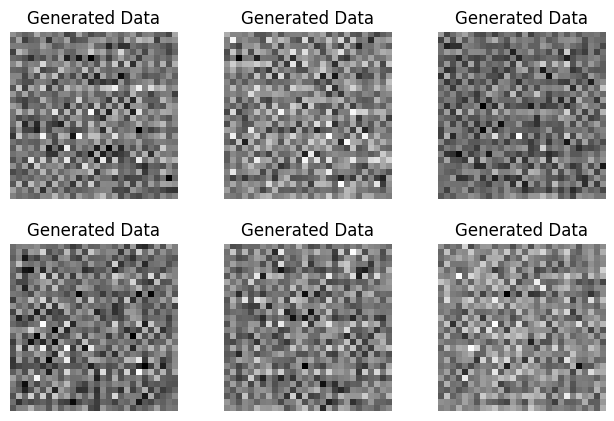

In [31]:
model.plot_imgs()

In [32]:
trainer = pl.Trainer(accelerator="cpu", max_epochs=20) # Replace 'gpus' with 'accelerator' and 'devices'
trainer.fit(model, dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | generator     | Generator     | 358 K  | train
1 | discriminator | Discriminator | 21.4 K | train
--------------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.520     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:6

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


epoch 20


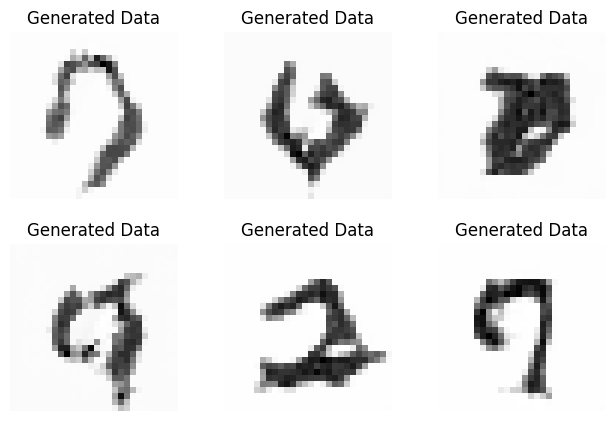

In [34]:
model.plot_imgs()